<a href="https://colab.research.google.com/github/ketan-lambat/DIP-Dehazing/blob/main/DIP_Dehazing_with_Dir_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from IPython.display import clear_output

In [ ]:
# from google.colab import drive, files
# drive.mount('/content/gdrive', force_remount=True)

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cd 'MyDrive/Dataset'

In [ ]:
cd '/content/drive/My Drive/Colab_Work/DIP'

/content/drive/My Drive/Colab_Work/DIP


In [ ]:
!pwd

/content/drive/My Drive/Colab_Work/DIP


## Calculating Dark Channel

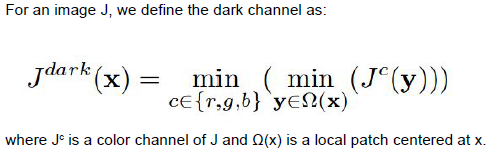

In [ ]:
def calculate_DCP(img, wind_size):
  """
  calculates the dark channel prior for the input image
  it select the pixel having low intensity within the patch
  cv2.copyMakeBorder() method is used to create a border around the image like a photo frame
  cv2.copyMakeBorder(src, top, bottom, left, right, borderType, value)
  """
  dcp = np.zeros((img.shape[0], img.shape[1]))
  border_size = wind_size//2
  img = cv2.copyMakeBorder(img, 
                           border_size,
                           border_size,
                           border_size,
                           border_size,
                           cv2.BORDER_CONSTANT, 
                           value=[255, 255, 255])
  num_rows = img.shape[0]
  num_cols = img.shape[1]
  min_channel = np.zeros((num_rows, num_cols))

  for row in range(num_rows):
    for col in range(num_cols):
      min_channel[row-border_size][col-border_size] = np.min(img[row, col, :]) #finds the minimum intensity in each channel

  for row in range(border_size, num_rows-border_size):
    for col in range(border_size, num_cols-border_size):
      dcp[row-border_size][col-border_size] = np.min(min_channel[row-border_size:row+border_size, col-border_size:col+border_size]) #calculates dark channel prior
      
  return dcp

## Estimating Atmospheric Light


In [ ]:
def calculate_ambience(im, dc_img):
  """
  Returns atmospheric ambience(brightness paramater "A")
  input -
  im  = original Image
  dc_img = dark channel prior of the orirginal image
  """
  img = im.copy()
  pixel_count = dc_img.size
  # print(pixel_count)
  count_brightest = pixel_count//1000  # pick the top 0.1% brightest pixels in the dark channel
  haze_density_sort_idx = np.argsort(dc_img, axis=None)[::-1]
  brightest = haze_density_sort_idx[0:count_brightest]
  brightest = np.unravel_index(brightest,dc_img.shape)
  brightest_pixels = img[brightest]
  top_intensities = np.average(brightest_pixels, axis=1)
  max_intensity = np.argmax(top_intensities) #finds maximum among the brightest pixel
  A = brightest_pixels[max_intensity]

  # to display the brightest pixels in the image
  img[brightest]=[255,0,0]
  row_min = np.min(brightest[0])
  row_max = np.max(brightest[0])
  col_min = np.min(brightest[1])
  col_max = np.max(brightest[1])
  
  # mark the brightest region in the image
  cv2.rectangle(img, 
                (col_min,row_min),
                (col_max,row_max),
                (0,0,255),
                thickness=2)
  
  # plt.figure(figsize=(10,10))
  # plt.imshow(img[...,::-1])
  # plt.show()
  return A

## Applying Guided Filter
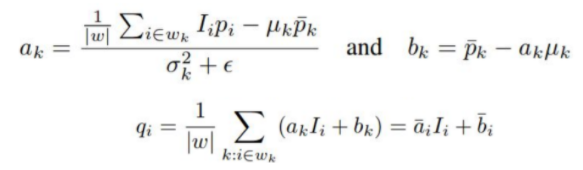

In [ ]:
def filter_image(img, transmission, filter_size, epsilon):
  """
  smoothen the input image(transmssion map) using guided filter.
  input -
  img = original image
  transmission = transmission t(x)
  filter_size = width of the guided filter
  epsilon  =  constant value

  output -
  q = egde preserved smoothen image

  """
  guide = cv2.blur(img,(filter_size,filter_size)) #smoothen the guiding image
  trans = cv2.blur(transmission,(filter_size,filter_size)) # smoothen the transmission map
  gt = cv2.blur(img * transmission, (filter_size,filter_size))
    
  a = gt - guide * trans
  var_guide = cv2.blur(img * img,(filter_size,filter_size)) - (guide *guide)
  a = a/(var_guide + epsilon)
  b = trans - a * guide

  q = cv2.blur(a,(filter_size,filter_size)) * img + cv2.blur(b,(filter_size,filter_size))
  return q

## Recovering Scene Radiance
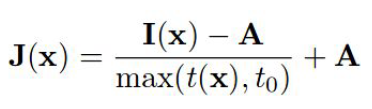

In [ ]:
def recover_image(img, trans_bar, atm_light, t0):
  """
  recover original image
  input -
  img = original image
  trans_bar = transmission map for hazed image
  atm  = atmospheric brightness A
  t0 = lower bound for t(x)

  output -
  j = dehazed image


  """
  trans_recover = np.copy(trans_bar)
  trans_recover[trans_recover < t0] = t0
  J = np.zeros((img.shape))

  J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0] #recovery got R channel
  J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1] #recovery for G channel
  J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2] #reovery for B channel
  
  return J


## Color Correction


In [ ]:
def color_balance(img, s):
  """
  since the haze removal also affects the brightness
  it enhance the color saturation of the dehazed image
  """
  out = np.copy(img)
  hist = np.zeros((256,1))
  no_of_pixels = img.shape[0] * img.shape[1]

  for i in range(3):
    channel_vals = img[:,:,i]

    for pixel_val in range(256):
      hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
    for pixel_val in range(256):
      hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]

    # clipping pixels
    Vmin = 0
    while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
      Vmin += 1
    Vmax = 255
    while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
      Vmax -= 1
    channel_vals[channel_vals < Vmin] = Vmin
    channel_vals[channel_vals > Vmax] = Vmax

    # normalize pixel values
    out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
  return out

## Calculate Depth Map

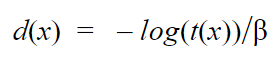

In [ ]:
def depth_map(t_refine, beta):
  """
  function to plot the depth map of the image 
  to find how distant an object in image actually is
  """
  x = -np.log(t_refine)/beta
  return x

In [ ]:

def histEqual(im):
  """ histogram equalization method for comparison """
  ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
  ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
  restored = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
  return restored

## Processing Image

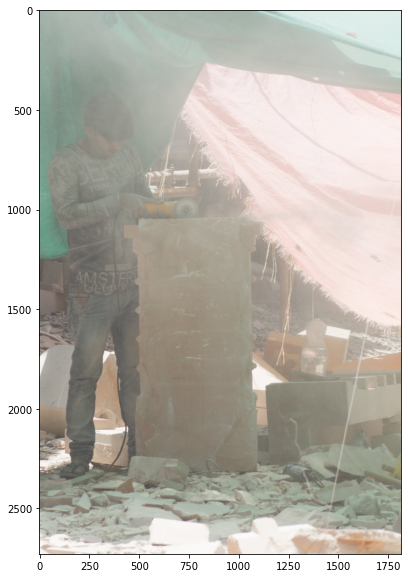

In [ ]:
# Input Image
filename = "haze15.jpg"
img = cv2.imread(filename)
img = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
plt.figure(figsize=(10,10))
plt.imshow(img[...,::-1])
plt.show()

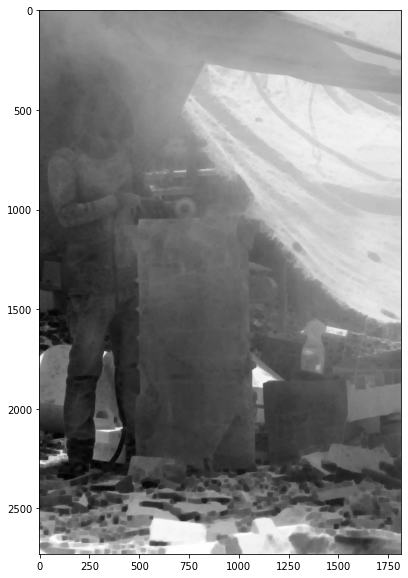

In [ ]:
# Show dark channel in image
dcp_img = calculate_DCP(img, 15)
dcp_img = dcp_img.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(dcp_img,'gray')
plt.show()

In [ ]:
# Plot the atmospheric light in image
# Red region
atm_light = calculate_ambience(img, dcp_img)

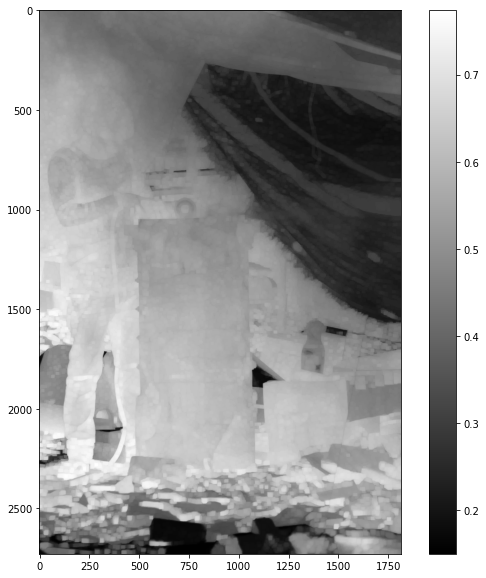

In [ ]:
# Plot Emission Transmission Map
# amt of light reaching the camera
t_bar = calculate_DCP(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.colorbar()
plt.show()

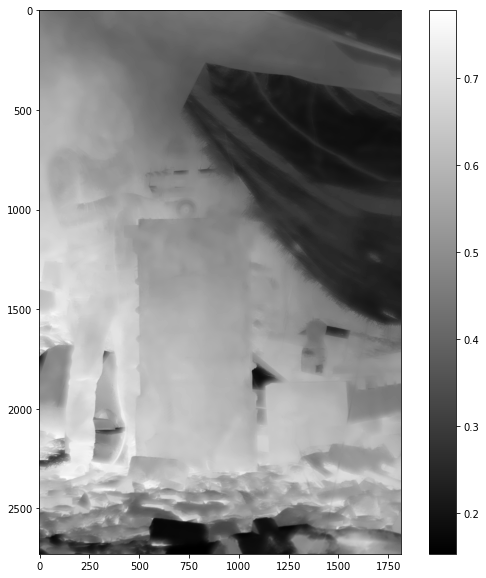

In [ ]:
# Refining the transmission map with a guided filter
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = filter_image(i, trans_bar, 30, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.colorbar()
plt.show()

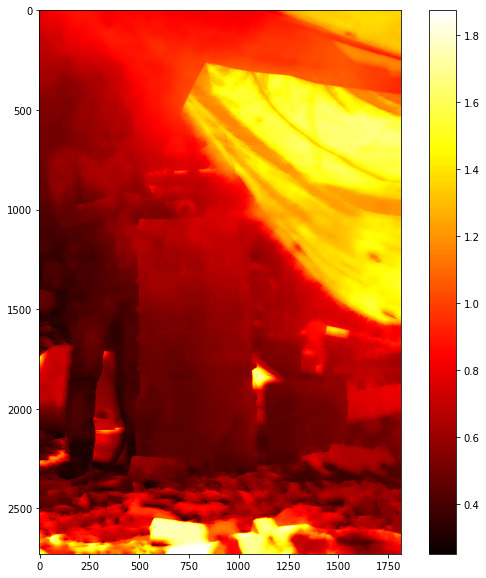

In [ ]:
# Depth map
# To show regions near (darker) and Far away (Lighter)
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()

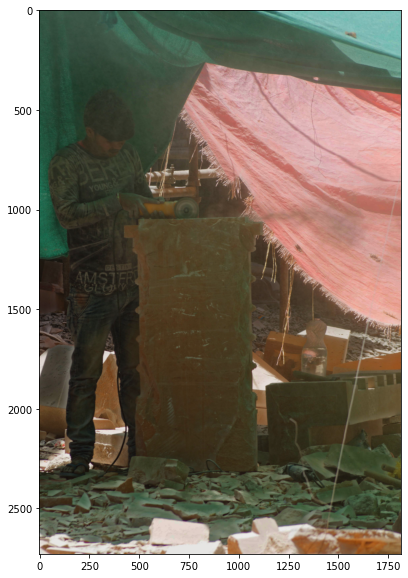

In [ ]:
# Output after restoring image
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()

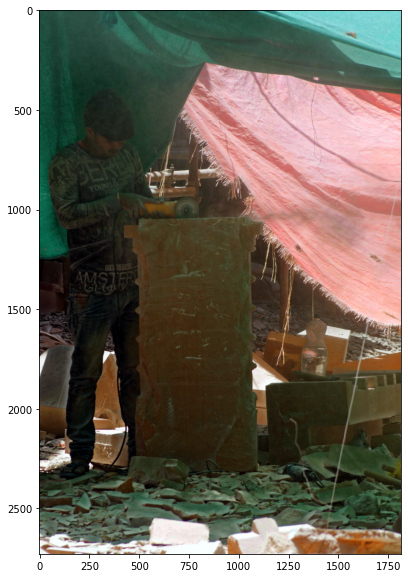

In [ ]:
# Output after color correction
cb_J = color_balance(np.uint8(J),0.005)
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(cb_J[...,::-1])))
plt.show()

In [ ]:
# J = histEqual(img)

# fig=plt.figure(figsize=(25,15))
# ax=fig.add_subplot(131)
# ax.imshow(img[...,::-1])
# ax.set_title("Input Image")
# ax.axis('off')

# ax=fig.add_subplot(132)
# ax.imshow(J[...,::-1])
# ax.set_title("Output from Histogram Equalization")
# ax.axis('off')

# ax=fig.add_subplot(133)
# ax.imshow(cb_J[...,::-1])
# ax.set_title("Output from Dark Channel Method")
# ax.axis('off')
# plt.show()

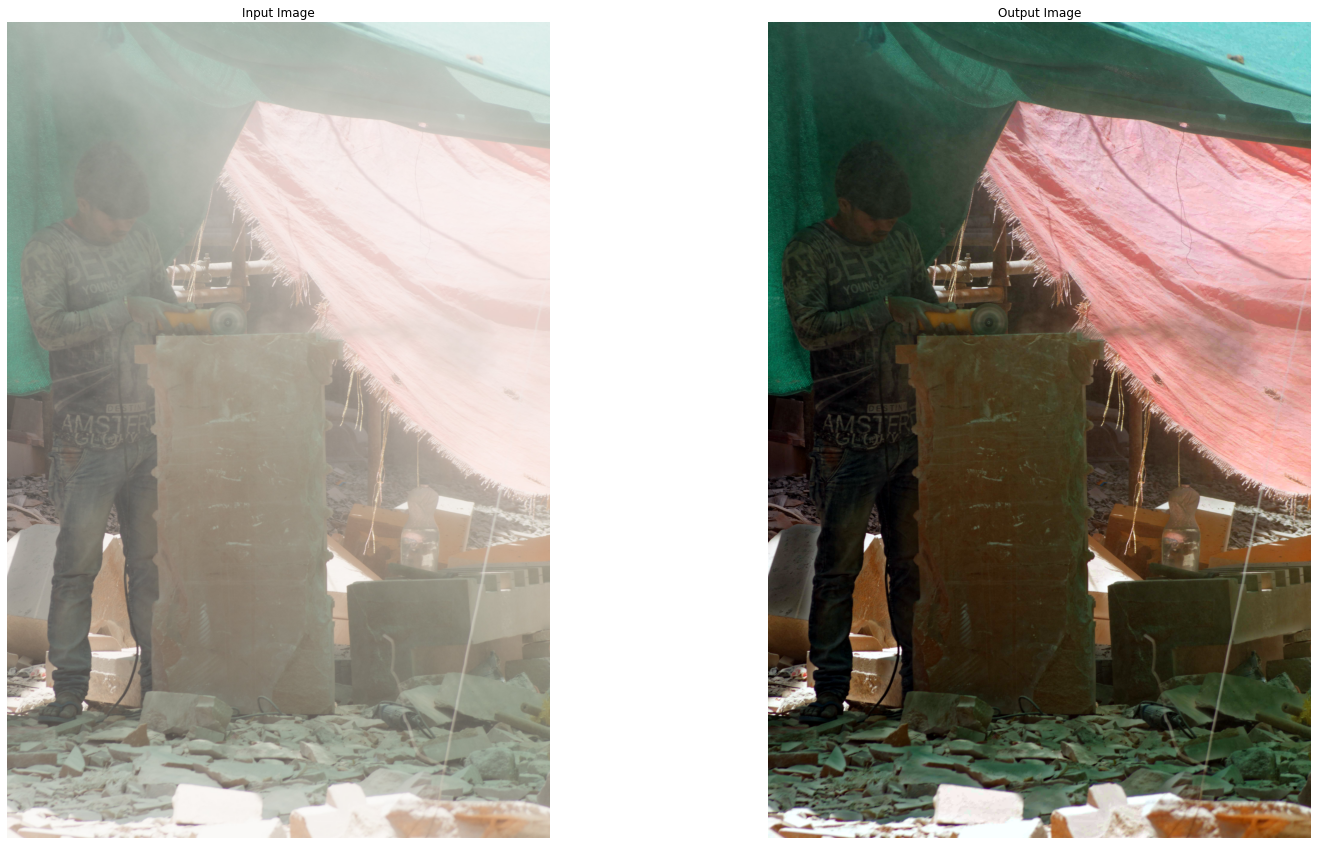

In [ ]:
fig=plt.figure(figsize=(25,15))
ax=fig.add_subplot(121)
ax.imshow(img[...,::-1])
ax.set_title("Input Image")
ax.axis('off')

ax=fig.add_subplot(122)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output Image")
ax.axis('off')
plt.show()

In [ ]:
name = filename.split('.')[0]
fig.savefig('./output/'+name+'_op.png', transparent=True, dpi=fig.dpi)

In [ ]:
def run(im_path, omega, t0, radius, dark_rad, gt_path=False):
  """
  Main Function to dehaze image by applying all the methods and calculate PSNR
  """
  img = cv2.imread(im_path)
  img = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
  dark_channel_img = calculate_DCP(img, dark_rad)
  dark_channel_img = dark_channel_img.astype('uint8')
  atm_light = calculate_ambience(img,dark_channel_img)
  t_bar = calculate_DCP(img/atm_light,dark_rad)
  trans_bar = 1-(omega * t_bar)
  i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
  t_refine = filter_image(i, trans_bar, radius, 0.0001)
  im = img.astype("double")
  J = recover_image(im, t_refine, atm_light, t0)
  J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
  cb_J = color_balance(np.uint8(J),0.005)
  op_img = cb_J
  if gt_path:
    gt = cv2.imread(gt_path)
    gt = cv2.resize(gt,(0,0),fx=1/6,fy=1/6)
    E = np.sum((cb_J-gt)**2)/gt.size
    return (10*np.log10(255*255/E))
  else:
    return img, op_img

In [ ]:
!pwd

/content/drive/My Drive/Colab_Work/DIP


In [ ]:
# gt = next(os.walk('./std_dataset/original/'))[2]
# gt.sort()
# hazy = next(os.walk('./std_dataset/synthetic/'))[2]
# hazy.sort()
# omega = np.arange(0,1.01,0.05)
# win_filter = np.arange(3,40,4)
# filter_rd = np.arange(10,101,10) 
# t0 = np.arange(0,1.01,0.1)
# PSNR = []
# l_b = 0
# max_p = None
# for om in omega:
#     for t in t0:
#         for f_size in filter_rd:
#             for win in win_filter:
#                 p = 0
#                 for i in range(len(gt)):
#                   print(i)
#                   p += run(os.path.join('./std_dataset/synthetic/',hazy[i]),
#                              om,t,f_size,win,
#                            os.path.join('./std_dataset/original/',gt[i]))
#                 if p/len(gt)  > l_b:
#                   max_p = [p/len(gt),om,t,f_size,win]
#                   l_b = p/len(gt)
                
#                 PSNR.append([p/len(gt),om,t,f_size,win])
# print(max_p)

In [ ]:
def batch_process_img(dir_path='./'):
  img_arr = next(os.walk(dir_path))[2]
  cnt = 0
  for img in img_arr:
    start = time.time()
    [ip_img, op_img] = run(img, 0.85, 0.1, 30, 15)
    fig=plt.figure(figsize=(25,15))
    ax=fig.add_subplot(121)
    ax.imshow(ip_img[...,::-1])
    ax.set_title("Input Image")
    ax.axis('off')

    ax=fig.add_subplot(122)
    ax.imshow(op_img[...,::-1])
    ax.set_title("Output Image")
    ax.axis('off')
    # plt.show()
    
    # name = img.split('.')[0]
    name = img
    fig.savefig('./output2/'+name+'_op.png', transparent=True, dpi=fig.dpi, bbox_inches='tight')
    plt.show()
    # plt.close(fig)
    t = time.time() - start
    cnt += 1
    print(cnt, img, t)
    clear_output(wait=True)


    # if(cnt>4):
    #   break

In [ ]:
# %%capture 
%%time
result = batch_process_img()

CPU times: user 40min 18s, sys: 5.9 s, total: 40min 24s
Wall time: 40min 24s
